/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean Absolute Error: 0.079273771989475
Mean Squared Error: 0.008723864368674929
R² Score: 0.9999801942279272


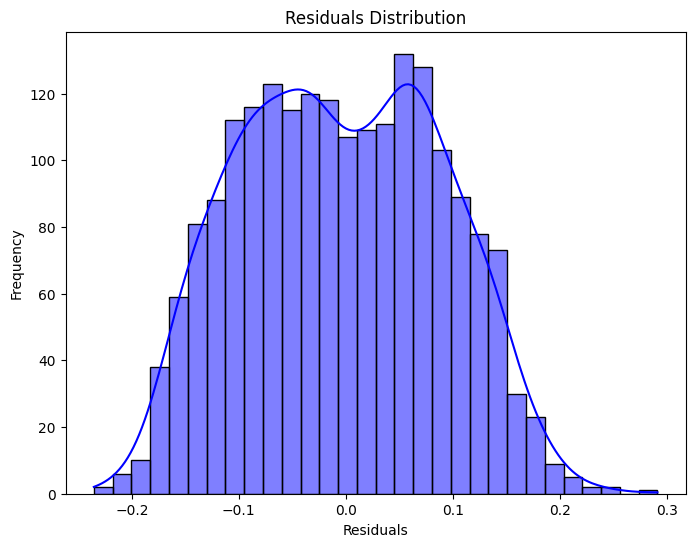

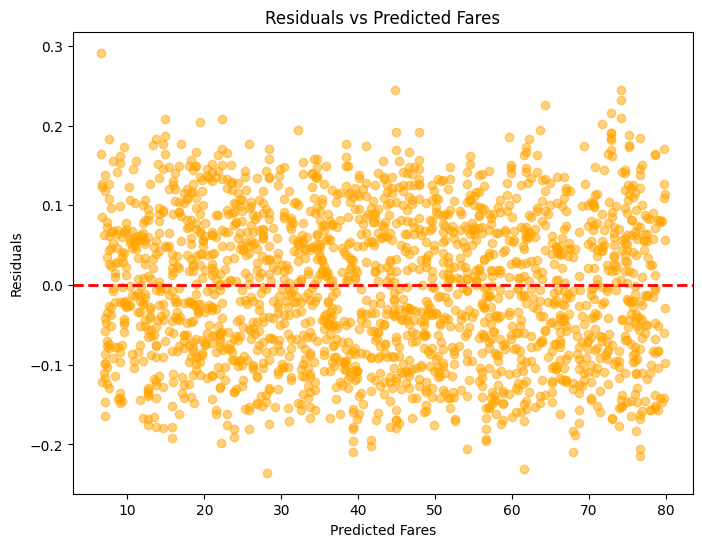

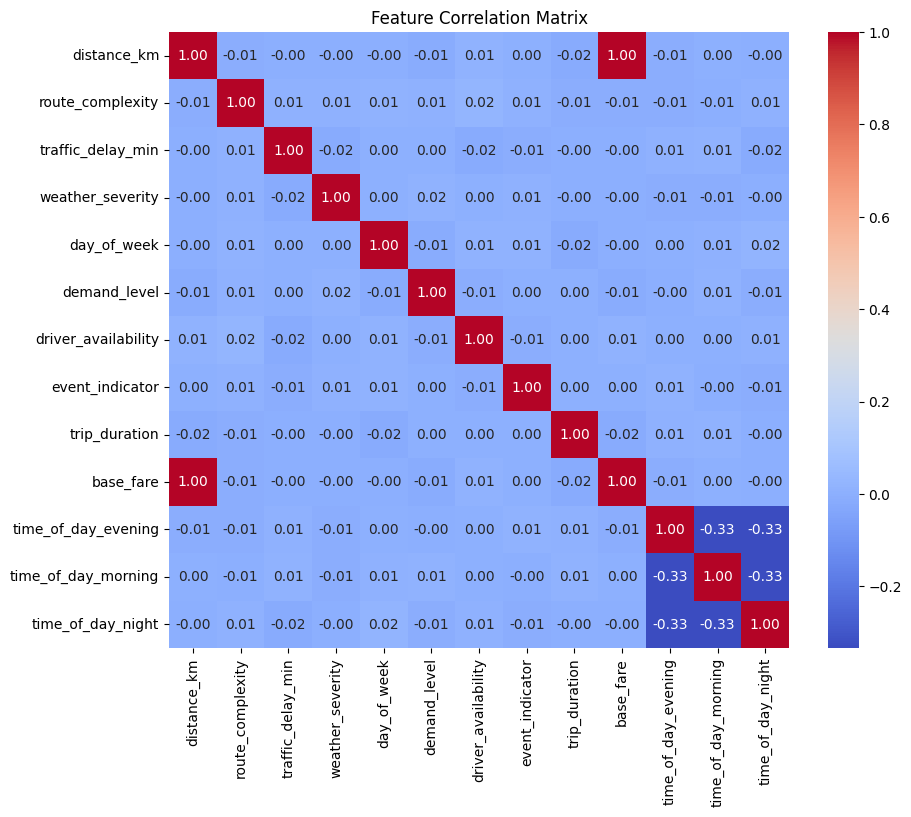

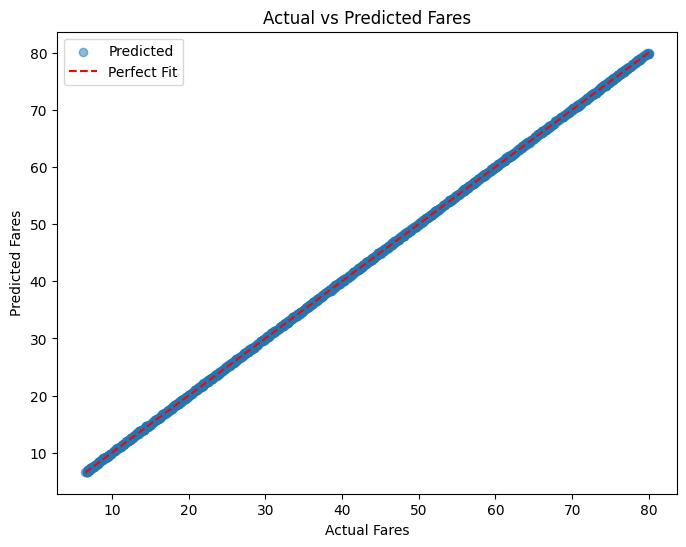

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib  # For saving the model
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/generated_taxi_fare_dataset.csv')

# Step 1: Data Preprocessing
data.dropna(inplace=True)

# One-Hot Encoding for Categorical Variables
data = pd.get_dummies(data, columns=['time_of_day'], drop_first=True)

# Normalize/Standardize Numerical Features
scaler = StandardScaler()
numerical_features = [
    'distance_km', 'route_complexity', 'traffic_delay_min',
    'weather_severity', 'day_of_week', 'demand_level',
    'driver_availability', 'event_indicator', 'trip_duration'
]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Feature and Target Separation
X = data.drop(columns=['base_fare'])
y = data['base_fare']

# Step 2: Split Dataset
train_test_data = X.iloc[:-50]  # First 9950 rows for training/testing
train_test_target = y.iloc[:-50]
input_data = X.iloc[-50:]  # Last 50 rows for prediction
input_target = y.iloc[-50:]

X_train, X_test, y_train, y_test = train_test_split(train_test_data, train_test_target, test_size=0.2, random_state=42)

# Step 3: Model Definition
# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Deep Neural Network (DNN)
def build_dnn(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

dnn_model = build_dnn(X_train.shape[1])
dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Ensemble Model
ensemble_model = StackingRegressor(
    estimators=[('xgb', xgb_model)],
    final_estimator=LinearRegression()
)
ensemble_model.fit(X_train, y_train)

# Save Models
joblib.dump(ensemble_model, 'ensemble_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Step 4: Evaluate the Model
y_pred_test = ensemble_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Step 5: Residual Analysis
residuals = y_test - y_pred_test

# Residuals Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5, color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Fares')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Fares')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()


# Step 7: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Fares')
plt.ylabel('Predicted Fares')
plt.title('Actual vs Predicted Fares')
plt.legend()
plt.show()

# Step 8: Predict on Input Data
input_predictions = ensemble_model.predict(input_data)

# Save Input Data and Predictions
input_data.to_csv('input_data.csv', index=False)
pd.DataFrame(input_predictions, columns=['Predicted_Fare']).to_csv('predicted_fares.csv', index=False)
